In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from models import glow
from flows.glow import resnet_glow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Input, Concatenate
from tensorflow.keras import Model

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
batch_size = 10
X_train = np.expand_dims(X_train, axis=-1)
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
X_train_ds = X_train_ds.map(lambda x: x / 255.).shuffle(buffer_size=1000).batch(batch_size)

In [3]:
#prior = tfp.distributions.Logistic(loc=2*tf.ones((1, *X_train.shape[1:])), scale=tf.ones((1, *X_train.shape[1:])))
def prior_model(input_shape):
    x = Input(input_shape)
    y = Conv2D(32, 5, activation='relu', padding='same')(x)
    y = Conv2D(32, 5, activation='relu', padding='same')(y)
    theta = Conv2D(2, 5, activation='linear', padding='same')(y)
    return Model(inputs=x, outputs=theta)

def logistic(bijector=tfp.bijectors.Identity(), axis=-1, epsilon=1.0E-6):
    def _logistic(params: tf.Tensor):
        mus = tf.gather(params, [0], axis=axis)
        log_scales = tf.gather(params, [1], axis=axis)
        base_dist = tfp.distributions.Logistic(loc=mus, scale=epsilon + tf.math.exp(log_scales), allow_nan_stats=False)
        transformed_dist = tfp.distributions.TransformedDistribution(base_dist, bijector=bijector)
        return transformed_dist
    return _logistic

In [4]:
model = glow.Glow(prior_model(X_train.shape[1:]), prior_parameterize=logistic(), num_layers=1, depth_per_layer=4, coupling_nn_ctor=resnet_glow(hidden_dims=64),
                  optimizer=tf.keras.optimizers.Adamax(lr=1.0E-3))

In [ ]:
from tqdm import tqdm
N = X_train.shape[0]
epochs = 2
with tqdm(total=N*epochs) as prog:
    n = 0
    for batch in X_train_ds.take(N//batch_size).repeat(epochs):
        n += batch_size
        loss, nll, prior, ildj, grad_norm = model.train_batch(batch)
        prog.update(batch_size)
        prog.set_postfix({'epoch': (n // N) + 1,
                          'loss': loss.numpy(),
                          'nll': nll.numpy(),
                          'prior': prior.numpy(),
                          'ildj': ildj.numpy(),
                          'grad norm': grad_norm.numpy()})

In [6]:
x = X_train[[i for i in np.random.randint(0, X_train.shape[0], size=6)]].astype(np.float32) / 255.
t = model.prior(x)
dist = model.prior_parameterize(t)

In [7]:
z = dist.sample()
x_ = model.glow.forward(z)
print(x_.shape)

(6, 28, 28, 1)


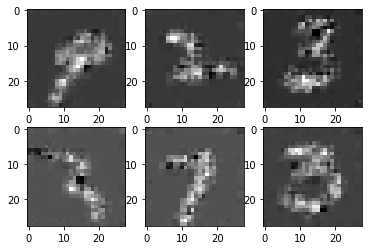

In [8]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_[i]), cmap='gray')
plt.show()